# Analysis of the _Sampson's Monks_ dataset

In [1]:
from pathlib import Path
from datetime import date
from dateutil.relativedelta import relativedelta
import json
import random
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import adjusted_mutual_info_score as ami
from msb import Balance
from msb.utils import frustration_index

#%matplotlib inline
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.3,
    palette="deep"
)

RED    = "#C52D25"
BLUE   = "#047DB7"
GRAY   = "#efefef"
COLORS = np.array(["#f97959", "#7aa063", "#60a1f7"])

# Paths
ROOT = Path(".").absolute().parent
DATA = ROOT/"data"/"congress"
FIGS = ROOT/"figs"
FIGS.mkdir(exist_ok=True)

# Get network datasets
NETWORKS = { "H": [], "S": [] }
for i in range(93, 115): 
    for chamber in ("H", "S"):
        G = ig.Graph.Read_GraphMLz(str(DATA/f"{chamber}{i}.graphml.gz"))
        NETWORKS[chamber].append(G)

# Balance params
BKWS = dict(m=10)

/home/sztal/miniconda3/envs/msb/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## US CONGRESS DATES (from: https://en.wikipedia.org/wiki/List_of_United_States_Congresses)
DATES = {
    (n+93): (date(1973+n*2, 1, 3), date(1974+n*2, 1, 3), date(1975+n*2, 1, 3))
    for n in range(len(NETWORKS["H"]))
}
## US PRESIDENTS (from: https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States)
with open(DATA/"presidents.json", "r") as fh:
    PRESIDENTS = json.loads(fh.read())

In [3]:
BALANCE = { 
    k: [ Balance(G, **BKWS) for G in tqdm(v) ]
    for k, v in NETWORKS.items()
}
BALANCE_WB = { 
    k: [ Balance(G, beta=1, semi=False, **BKWS) for G in tqdm(v) ]
    for k, v in NETWORKS.items()
} 

100%|██████████| 22/22 [00:00<00:00, 550.61it/s]


In [4]:
## NETWORK DESCRIPTIVE STATISTICS
stats = pd.concat([ pd.DataFrame({
    "congress": [ int(G["congress"]) for G in v ],
    "n_rep":    [ sum(1 for x in G.vs["party"] if x == "R") for G in v],
    "n_dem":    [ sum(1 for x in G.vs["party"] if x == "D") for G in v],
    "n_oth":    [ sum(1 for x in G.vs["party"] if x not in ("R", "D")) for G in v],
    "n_nodes":  [ G.vcount() for G in v ],
    "n_edges":  [ G.ecount() for G in v ],  
    "n_pos":    [ len(G.es.select(weight_lt=0)) for G in v ],
    "n_neg":    [ len(G.es.select(weight_gt=0)) for G in v ],
    "dobs":     [ B.balance(beta=B.beta.max(), weak=False) for B in BALANCE[k] ],
    "dobw":     [ B.balance(beta=B.beta.max(), weak=True) for B in BALANCE[k] ],
    "dbar":     [ np.mean(G.degree()) for G in v ],
    "dstd":     [ np.std(G.degree()) for G in v ]
}) for k, v in NETWORKS.items() ], keys=list(NETWORKS), names=["chamber"]) \
    .assign(
        dcv=lambda df: df["dstd"]/df["dbar"],
        f_pos=lambda df: df["n_pos"] / df["n_edges"],
        f_neg=lambda df: df["n_neg"] / df["n_edges"],
        f_rep=lambda df: df["n_rep"] / df["n_nodes"],
        f_dem=lambda df: df["n_dem"] / df["n_nodes"]
    ) \
    .reset_index(level=-1, drop=True) \
    .set_index("congress", append=True)

In [5]:
## MAKE TABLE
cols = ["f_rep", "f_dem", "n_nodes", "n_edges", "f_pos", "dobs", "dobw", "dbar", "dcv"]
ltx = pd.concat([
    stats.loc[chamber, cols] for chamber in NETWORKS
], axis=1, keys=["House", "Senate"], names=["chamber"]) \
    .stack(level="chamber") \
    .swaplevel() \
    .loc[["House", "Senate"], cols] \
    .style.format(precision=2) \
    .to_latex()

# print(ltx)

In [6]:
## Clustering
CLUSTERS = {
    k: [ B.find_clusters(max_clusters=200, full_results=True) for B in tqdm(v) ]
    for k, v in BALANCE.items()
}

100%|██████████| 22/22 [02:35<00:00,  7.06s/it]


In [7]:
def get_best_clust(df, cols=("fidx_s", "fidx_w")):
    cols = list(cols)
    fcol = df[cols].min().idxmin()
    idx  = df[fcol].idxmin()
    mode = fcol.split("_")[-1]
    return df.loc[idx, "hc_"+mode].labels_

## Data for analysis 
cols = ["fidx_s", "fidx_w"]
cong = [ int(G["congress"]) for G in NETWORKS["H"] ]
pres = pd.DataFrame(PRESIDENTS)[["name", "midname", "surname", "affil", "start", "end"]] \
    .assign(
        start=lambda df: pd.to_datetime(df["start"]),
        end=lambda df: pd.to_datetime(df["end"])
    )

data = pd.concat([ pd.DataFrame({
    "congress": cong,
    "start":    [ DATES[c][0] for c in cong ],
    "mid":      [ DATES[c][1] for c in cong ],
    "end":      [ DATES[c][2] for c in cong ],
    "n":        [ df.set_index("n")[cols].idxmin().min() for df in v ],
    "fbip":     [
        (c := np.sort(np.unique(get_best_clust(cdf), return_counts=True)[1]))[-2:].sum() / c.sum()
        for cdf in CLUSTERS[k]
    ],
    "fidx":     [ df.set_index("n")[cols].min().min() for df in v ],
    "fidx2":    [ df.set_index("n").loc[2, cols].min().min() for df in v ],
    "fidxp":    [ frustration_index(B.S, G.vs["party"]) for G, B in zip(NETWORKS[k], BALANCE[k]) ],
    "amip":     [ 
        ami(
            G.vs["party"],
            get_best_clust(cdf, cols=cols)
        ) for G, cdf in zip(NETWORKS[k], CLUSTERS[k]) 
    ],
    "amip2":    [ 
        ami(G.vs["party"], cdf.loc[cdf["n"] == 2, "hc_s"].to_numpy()[0].labels_,) 
        for G, cdf in zip(NETWORKS[k], CLUSTERS[k]) 
    ],
    "dobs":     [ B.balance(beta=B.beta.max(), weak=False) for B in BALANCE[k] ],
    "dobw":     [ B.balance(beta=B.beta.max(), weak=True) for B in BALANCE[k] ],
    "dobs1":    [ B.balance(beta=1, weak=False) for B in BALANCE_WB[k] ],
    "dobw1":    [ B.balance(beta=1, weak=True) for B in BALANCE_WB[k] ]   
}) for k, v in CLUSTERS.items() ], axis=0, keys=list(CLUSTERS), names=["chamber"]) \
    .reset_index(level=0) \
    .reset_index(drop=True)

## Time series (House)

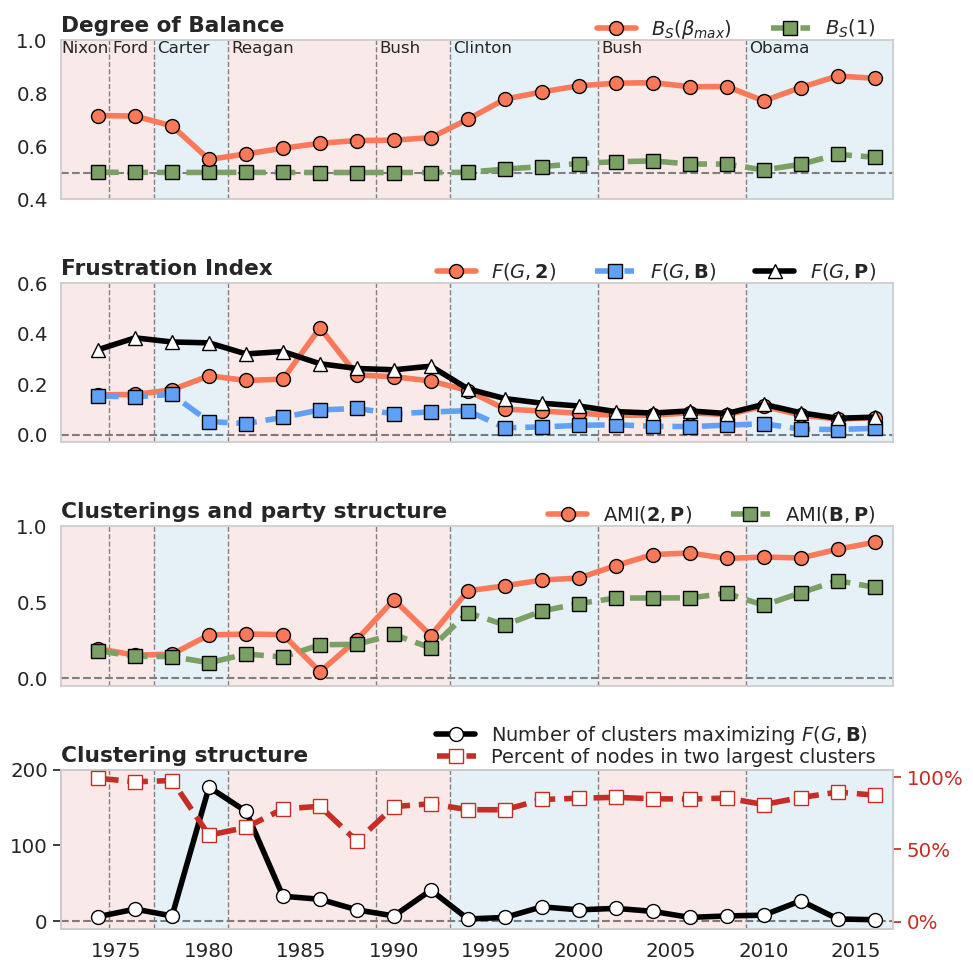

In [8]:
fig, axes = plt.subplots(nrows=4, figsize=(10, 10))

date0   = data["start"].min() - relativedelta(years=1)
chamber = "H"
title   = "House" if chamber == "H" else "Senate"
df      = data.set_index("chamber").loc[chamber]

ax = axes[0]
ax.axhline(.5, ls="--", color="gray")

x  = df["mid"]
y  = df["dobs"]
c  = COLORS[0]
pkws = dict(markersize=10, markeredgecolor="black")
ax.plot(
    x, y, color=c, linewidth=4, marker="o", zorder=11, **pkws,
    label=r"$B_S(\beta_{max})$"
)
y = df["dobs1"]
c = COLORS[1]
ax.plot(
    x, y, color=c, linewidth=4, ls="--", marker="s", zorder=10, **pkws,
    label=r"$B_S(1)$"
)
ax.get_xaxis().set_ticklabels([])
ax.set_title("Degree of Balance", fontweight="bold", ha="left", x=0)
ax.set_ylim(.4, 1)
ax.legend(
    loc="upper right", ncol=2, frameon=False,
    fontsize=14, bbox_to_anchor=(1, 1.25)
)

ax = axes[1]
x  = df["mid"]
y  = df["fidx2"]
c  = COLORS[0]
ax.plot(
    x, y, color=c, linewidth=4, zorder=5, marker="o", **pkws,
    label=r"$F(G, \mathbf{2})$"
)
y  = df["fidx"]
c  = COLORS[2]
ax.plot(
    x, y, color=c, linewidth=4, ls="--", zorder=5, marker="s", **pkws,
    label=r"$F(G, \mathbf{B})$"
)
y = df["fidxp"]
c = "black"
ax.plot(
    x, y, color=c, linewidth=4, zorder=5, marker="^", **pkws,
    markerfacecolor="white",
    label=r"$F(G, \mathbf{P})$"
)
ax.set_ylim(-.03, .6)
ax.axhline(0, ls="--", color="gray", zorder=1)
ax.set_title("Frustration Index", fontweight="bold", ha="left", x=0)
ax.get_xaxis().set_ticklabels([])
ax.legend(
    loc="upper right", ncol=3, frameon=False,
    fontsize=14, bbox_to_anchor=(1, 1.25)
)

ax = axes[2]
y  = df["amip2"]
c  = COLORS[0]
ax.plot(
    x, y, color=c, linewidth=4, zorder=5, marker="o", **pkws,
    label=r"AMI($\mathbf{2}, \mathbf{P}$)"
)
y  = df["amip"]
c  = COLORS[1]
ax.plot(
    x, y, color=c, linewidth=4, zorder=5, marker="s", ls="--", **pkws,
    label=r"AMI($\mathbf{B}, \mathbf{P}$)"
)
ax.set_ylim(-.05, 1)
ax.axhline(0, ls="--", color="gray")
ax.get_xaxis().set_ticklabels([])
ax.legend(
    loc="upper right", ncol=3, frameon=False,
    fontsize=14, bbox_to_anchor=(1, 1.25)
)
ax.set_title(
    "Clusterings and party structure",
    fontweight="bold", ha="left", x=0
)


ax = axes[3]
y  = df["n"]
c  = "black"
ax.plot(
    x, y, color=c, linewidth=4, zorder=5, marker="o", **pkws,
    markerfacecolor="white",
    label=r"Number of clusters maximizing $F(G, \mathbf{B})$"
)
ax.axhline(0, ls="--", color="gray", zorder=1)
ax.set_ylim(-10, 200)
ax.set_title(
    "Clustering structure",
    fontweight="bold", ha="left", x=0
)
ax.legend(
    loc="upper right", ncol=3, frameon=False,
    fontsize=14, bbox_to_anchor=(.99, 1.4)
)
ax = ax.twinx()
y  = df["fbip"]
c  = RED
ax.plot(
    x, y, color=c, linewidth=4, zorder=6, marker="s", ls="--",
    markerfacecolor="white", **{**pkws, "markeredgecolor": RED },
    label="Percent of nodes in two largest clusters"
)
ax.set_ylim(-.05, 1.05)
ax.grid(False)
ax.yaxis.label.set_color(RED)
ax.tick_params(axis="y", colors=RED)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
ax.legend(
    loc="upper right", ncol=1, frameon=False,
    fontsize=14, bbox_to_anchor=(1, 1.25)
)

for ax in axes:
    ax.set_xlim(date0, data["end"].max())
    ax.grid(False)
    for _, row in pres.iterrows():
        color = RED if row["affil"] == "Republican" else BLUE
        ax.fill_between(row[["start", "end"]], -100, 400, color=color, alpha=.1, linewidth=0)
        name  = row["surname"]
        start = row["start"].date()
        x     = max(date0, start  + relativedelta(months=2))
        y     = .95 if ax is axes[0] else .55

        if ax is axes[0]:
            ax.text(x, y, name, size=12)
        if start > date0:
            ax.axvline(start, ls="--", color="gray", linewidth=1, zorder=1)


fig.tight_layout()
fig.savefig(FIGS/"congress-house.pdf", bbox_inches="tight")

## Time series (Senate)

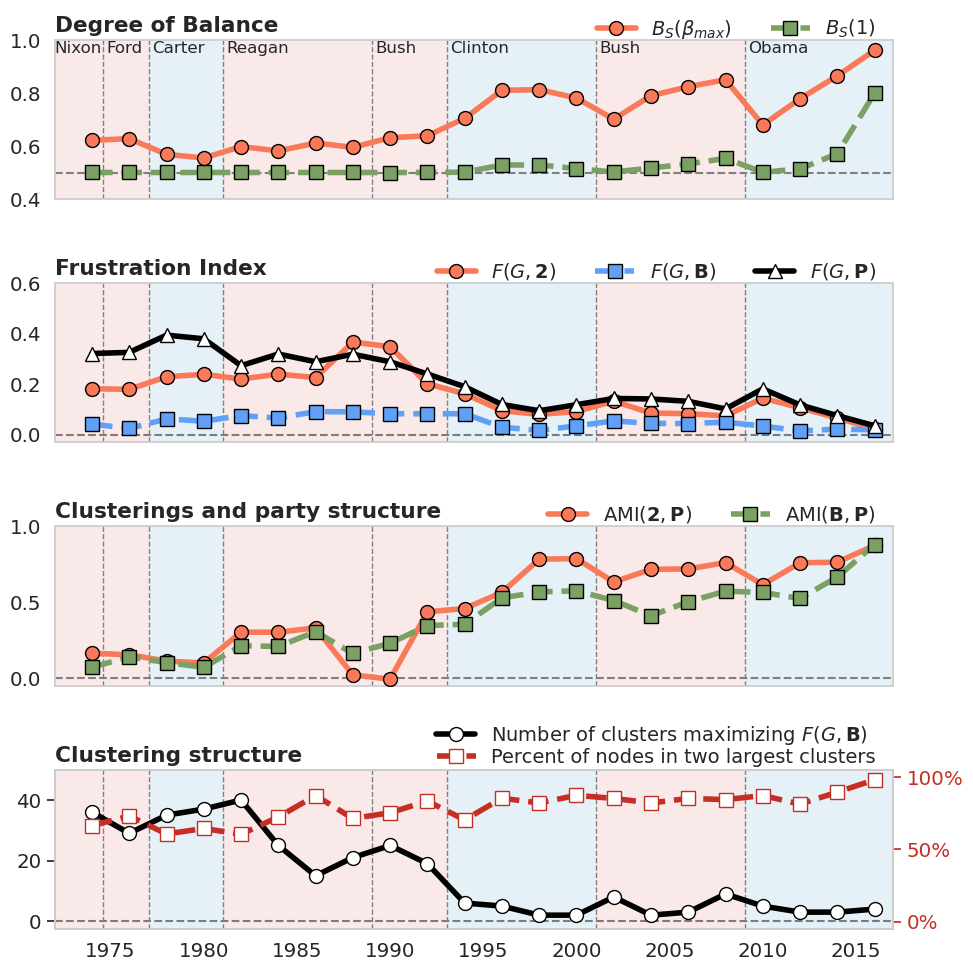

In [9]:
fig, axes = plt.subplots(nrows=4, figsize=(10, 10))

date0   = data["start"].min() - relativedelta(years=1)
chamber = "S"
title   = "House" if chamber == "H" else "Senate"
df      = data.set_index("chamber").loc[chamber]

ax = axes[0]
ax.axhline(.5, ls="--", color="gray")

x  = df["mid"]
y  = df["dobs"]
c  = COLORS[0]
pkws = dict(markersize=10, markeredgecolor="black")
ax.plot(
    x, y, color=c, linewidth=4, marker="o", zorder=11, **pkws,
    label=r"$B_S(\beta_{max})$"
)
y = df["dobs1"]
c = COLORS[1]
ax.plot(
    x, y, color=c, linewidth=4, ls="--", marker="s", zorder=10, **pkws,
    label=r"$B_S(1)$"
)
ax.get_xaxis().set_ticklabels([])
ax.set_title("Degree of Balance", fontweight="bold", ha="left", x=0)
ax.set_ylim(.4, 1)
ax.legend(
    loc="upper right", ncol=2, frameon=False,
    fontsize=14, bbox_to_anchor=(1, 1.25)
)

ax = axes[1]
x  = df["mid"]
y  = df["fidx2"]
c  = COLORS[0]
ax.plot(
    x, y, color=c, linewidth=4, zorder=5, marker="o", **pkws,
    label=r"$F(G, \mathbf{2})$"
)
y  = df["fidx"]
c  = COLORS[2]
ax.plot(
    x, y, color=c, linewidth=4, ls="--", zorder=5, marker="s", **pkws,
    label=r"$F(G, \mathbf{B})$"
)
y = df["fidxp"]
c = "black"
ax.plot(
    x, y, color=c, linewidth=4, zorder=5, marker="^", **pkws,
    markerfacecolor="white",
    label=r"$F(G, \mathbf{P})$"
)
ax.set_ylim(-.03, .6)
ax.axhline(0, ls="--", color="gray", zorder=1)
ax.set_title("Frustration Index", fontweight="bold", ha="left", x=0)
ax.get_xaxis().set_ticklabels([])
ax.legend(
    loc="upper right", ncol=3, frameon=False,
    fontsize=14, bbox_to_anchor=(1, 1.25)
)

ax = axes[2]
y  = df["amip2"]
c  = COLORS[0]
ax.plot(
    x, y, color=c, linewidth=4, zorder=5, marker="o", **pkws,
    label=r"AMI($\mathbf{2}, \mathbf{P}$)"
)
y  = df["amip"]
c  = COLORS[1]
ax.plot(
    x, y, color=c, linewidth=4, zorder=5, marker="s", ls="--", **pkws,
    label=r"AMI($\mathbf{B}, \mathbf{P}$)"
)
ax.set_ylim(-.05, 1)
ax.axhline(0, ls="--", color="gray")
ax.get_xaxis().set_ticklabels([])
ax.legend(
    loc="upper right", ncol=3, frameon=False,
    fontsize=14, bbox_to_anchor=(1, 1.25)
)
ax.set_title(
    "Clusterings and party structure",
    fontweight="bold", ha="left", x=0
)


ax = axes[3]
y  = df["n"]
c  = "black"
ax.plot(
    x, y, color=c, linewidth=4, zorder=5, marker="o", **pkws,
    markerfacecolor="white",
    label=r"Number of clusters maximizing $F(G, \mathbf{B})$"
)
ax.axhline(0, ls="--", color="gray", zorder=1)
ax.set_ylim(-2.5, 50)
ax.set_title(
    "Clustering structure",
    fontweight="bold", ha="left", x=0
)
ax.legend(
    loc="upper right", ncol=3, frameon=False,
    fontsize=14, bbox_to_anchor=(.99, 1.4)
)
ax = ax.twinx()
y  = df["fbip"]
c  = RED
ax.plot(
    x, y, color=c, linewidth=4, zorder=6, marker="s", ls="--",
    markerfacecolor="white", **{**pkws, "markeredgecolor": RED },
    label="Percent of nodes in two largest clusters"
)
ax.set_ylim(-.05, 1.05)
ax.grid(False)
ax.yaxis.label.set_color(RED)
ax.tick_params(axis="y", colors=RED)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
ax.legend(
    loc="upper right", ncol=1, frameon=False,
    fontsize=14, bbox_to_anchor=(1, 1.25)
)

for ax in axes:
    ax.set_xlim(date0, data["end"].max())
    ax.grid(False)
    for _, row in pres.iterrows():
        color = RED if row["affil"] == "Republican" else BLUE
        ax.fill_between(row[["start", "end"]], -100, 400, color=color, alpha=.1, linewidth=0)
        name  = row["surname"]
        start = row["start"].date()
        x     = max(date0, start  + relativedelta(months=2))
        y     = .95 if ax is axes[0] else .55

        if ax is axes[0]:
            ax.text(x, y, name, size=12)
        if start > date0:
            ax.axvline(start, ls="--", color="gray", linewidth=1, zorder=1)


fig.tight_layout()
fig.savefig(FIGS/"congress-senate.pdf", bbox_inches="tight")

## Visualization of sample networks

Below we visualize Senate co-sponsorship networks from late Carter
administration (96th Congress, 1979, low polarization) and late Obama
administration (114th Congress, 2015, high polarization).

In [10]:
CMAP = {
    "R": "#D81F29",
    "D": "#00AEF3",
    "O": "gray"
}
PARTIES = { 
    "R": "Republican",
    "D": "Democrat",
    "O": "Other"
}

G1 = NETWORKS["S"][3]
G2 = NETWORKS["S"][-1]
DATES[96]

(datetime.date(1979, 1, 3),
 datetime.date(1980, 1, 3),
 datetime.date(1981, 1, 3))

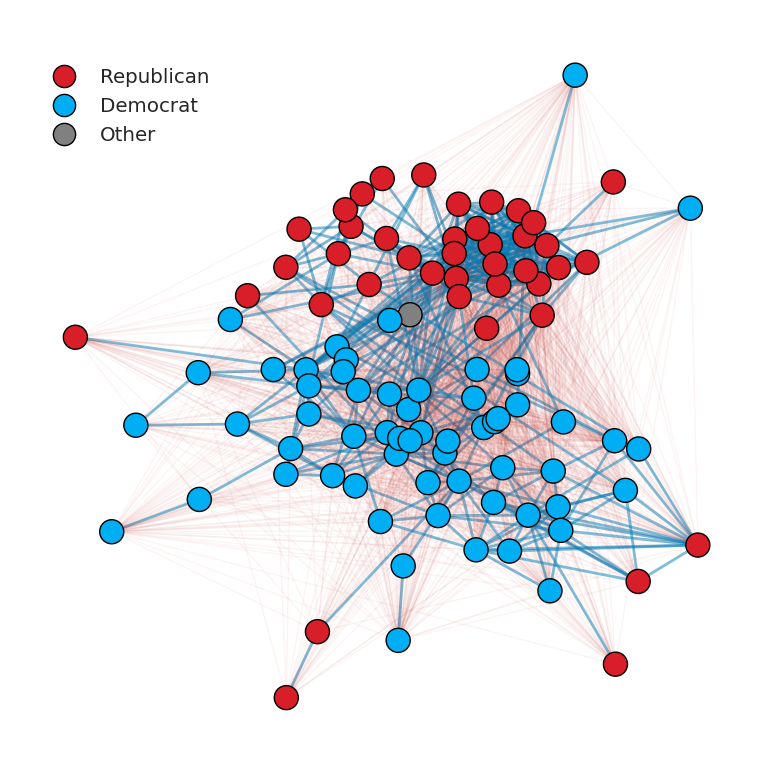

In [11]:
import random
random.seed(303)

fig, ax = plt.subplots(figsize=(8, 8))

G = G1
congress = G["congress"]
party = np.array(G.vs["party"])
party = np.where(np.isin(party, ["R", "D"]), party, "O")
pidx  = pd.Categorical(party).codes

Gp = G.copy()
Gp.es.select(weight_lt=0).delete()
weights = np.array(Gp.es["weight"])
vc = ig.VertexClustering(Gp, membership=pidx)
Gp.es["weight"] = np.where(vc.crossing(), 2*weights, weights) 
pos = nx.kamada_kawai_layout(Gp.to_networkx()) 
N = G.to_networkx()
kwds = dict(G=N, pos=pos, ax=ax)

ecolors = [ RED if e["weight"] < 0 else BLUE for e in N.edges.values() ]
ealphas = [ .05 if e["weight"] < 0 else .5 for e in N.edges.values() ]
ewidths = [ 1 if e["weight"] < 0 else 2 for e in N.edges.values() ]
nx.draw_networkx_edges(**kwds, edge_color=ecolors, alpha=ealphas, width=ewidths)

x, y = np.stack(list(pos.values())).T
ncolors = [ CMAP[f] for f in party ]
ax.scatter(
    x, y, color=ncolors, edgecolors="black", s=300,
    marker="o"
)
ax.axis("off")

handles = [
    mpl.lines.Line2D(
        [0], [0], color=CMAP[p], lw=0, label=PARTIES[p], 
        marker="o", markersize=16, markeredgecolor="black"
    ) for p in PARTIES
]
fig.legend(
    handles=handles, loc="center left", ncol=1,
    frameon=False, bbox_to_anchor=(.05, .85)
)

fig.tight_layout()
fig.savefig(FIGS/"congress-examples-1.pdf", bbox_inches="tight")

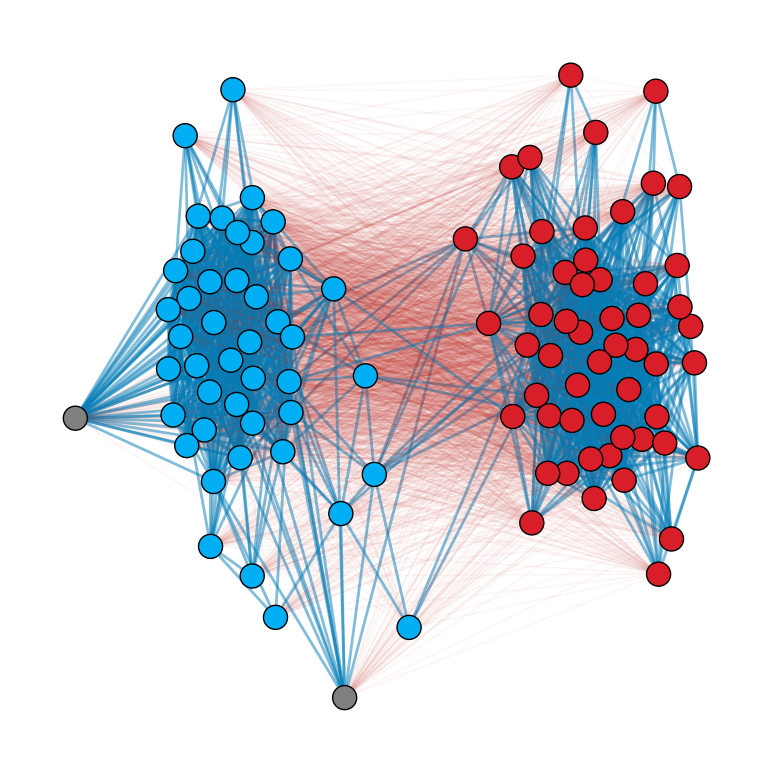

In [12]:
import random
random.seed(303)

fig, ax = plt.subplots(figsize=(8, 8))

G = G2
congress = G["congress"]
party = np.array(G.vs["party"])
party = np.where(np.isin(party, ["R", "D"]), party, "O")
pidx  = pd.Categorical(party).codes

Gp = G.copy()
Gp.es.select(weight_lt=0).delete()
weights = np.array(Gp.es["weight"])
vc = ig.VertexClustering(Gp, membership=pidx)
Gp.es["weight"] = np.where(vc.crossing(), 2*weights, weights) 
pos = nx.kamada_kawai_layout(Gp.to_networkx()) 
N = G.to_networkx()
kwds = dict(G=N, pos=pos, ax=ax)

ecolors = [ RED if e["weight"] < 0 else BLUE for e in N.edges.values() ]
ealphas = [ .05 if e["weight"] < 0 else .5 for e in N.edges.values() ]
ewidths = [ 1 if e["weight"] < 0 else 2 for e in N.edges.values() ]
nx.draw_networkx_edges(**kwds, edge_color=ecolors, alpha=ealphas, width=ewidths)

x, y = np.stack(list(pos.values())).T
ncolors = [ CMAP[f] for f in party ]
ax.scatter(
    x, y, color=ncolors, edgecolors="black", s=300,
    marker="o"
)
ax.axis("off")

fig.tight_layout()
fig.savefig(FIGS/"congress-examples-2.pdf", bbox_inches="tight")